<a href="https://colab.research.google.com/github/boroju/aidl-upc-winter2024-satellite-imagery/blob/main/notebooks/jose/MODIS_ee_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Data & Masks



*   Using: [MODIS-ee.ipynb](https://colab.research.google.com/drive/1QBZaUC6eyeYfym5mMTXx0q2We3uyo_qH#scrollTo=bk3qErKT9b0c&uniqifier=1)




The challenges
In traditional computer vision datasets, such as ImageNet, the image files themselves tend to be rather simple and easy to work with. Most images have 3 spectral bands (RGB), are stored in common file formats like PNG or JPEG, and can be easily loaded with popular software libraries like PIL or OpenCV. Each image in these datasets is usually small enough to pass directly into a neural network. Furthermore, most of these datasets contain a finite number of well-curated images that are assumed to be independent and identically distributed, making train-val-test splits straightforward. As a result of this relative homogeneity, the same pre-trained models (e.g., CNNs pretrained on ImageNet) have shown to be effective across a wide range of vision tasks using transfer learning methods. Existing libraries, such as torchvision, handle these simple cases well, and have been used to make large advances in vision tasks over the past decade.

Remote sensing imagery is not so uniform. Instead of simple RGB images, satellites tend to capture images that are multispectral (Landsat 8 has 11 spectral bands) or even hyperspectral (Hyperion has 242 spectral bands). These images capture information at a wider range of wavelengths (400 nm–15 µm), far outside of the visible spectrum. Different satellites also have very different spatial resolutions—GOES has a resolution of 4 km/px, Maxar imagery is 30 cm/px, and drone imagery resolution can be as high as 7 mm/px. These datasets almost always have a temporal component, with satellite revisists that are daily, weekly, or biweekly. Images often have overlap with other images in the dataset, and need to be stitched together based on geographic metadata. These images tend to be very large (e.g., 10K x 10K pixels), so it isn’t possible to pass an entire image through a neural network. This data is distributed in hundreds of different raster and vector file formats like GeoTIFF and ESRI Shapefile, requiring specialty libraries like GDAL to load.

Although each image is 2D, the Earth itself is 3D. In order to stitch together images, they first need to be projected onto a 2D representation of the Earth, called a coordinate reference system (CRS). Most people are familiar with equal angle representations like Mercator that distort the size of regions (Greenland looks larger than Africa even though Africa is 15x larger), but there are many other CRSs that are commonly used. Each dataset may use a different CRS, and each image within a single dataset may also be in a unique CRS. In order to use data from multiple layers, they must all share a common CRS, otherwise the data won’t be properly aligned. For those who aren’t familiar with remote sensing data, this can be a daunting task.

## Setup

In [61]:
# %pip install odc-stac -q
# %pip install planetary_computer -q
# %pip install 'stackstac[viz]' -q
# %pip install zen3geo -q
# %pip install pyogrio[geopandas] -q
# %pip install xbatcher  -q
# %pip install wxee -q
%pip install geedim -q
%pip install torchgeo -q
%pip install rioxarray -q

In [62]:
# Geospatial libraries
# import pystac
# import pystac_client
# import planetary_computer
import rioxarray
# Deep Learning libraries
import torch
import torchdata
# import zen3geo

In [63]:
# print(f"pystac version: {pystac.__version__}")
# print(f"planetary-computer version: {planetary_computer.__version__}")
print(f"torch version: {torch.__version__}")

print(f"torchdata version: {torchdata.__version__}")
# print(f"zen3geo version: {zen3geo.__version__}")
rioxarray.show_versions()

torch version: 2.1.0+cu121
torchdata version: 0.7.0
rioxarray (0.15.1) deps:
  rasterio: 1.3.9
    xarray: 2023.7.0
      GDAL: 3.6.4
      GEOS: 3.11.1
      PROJ: 9.0.1
 PROJ DATA: /usr/local/lib/python3.10/dist-packages/rasterio/proj_data
 GDAL DATA: None

Other python deps:
     scipy: 1.11.4
    pyproj: 3.6.1

System:
    python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
executable: /usr/bin/python3
   machine: Linux-6.1.58+-x86_64-with-glibc2.35


In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
import ee

ee.Authenticate()
ee.Initialize(project='ee-joseramoncajide')

## 2021 Dixie Wildfire in California

In [66]:
# 2021 Dixie Wildfire in California
latitude = 40.7310
longitude = -122.9420
location = [longitude, latitude]
# area_of_interest or geometry
area_of_interest = {
    "type": "Point",
    "coordinates": location,
}
datetimes = [
    "2021-07-12",
    "2021-07-20",
    "2021-07-28",
    "2021-08-05",
    "2021-08-13",
    "2021-08-21",
]

print(area_of_interest)
buffer = 0.7
bbox_list = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]
print('* bbox:', bbox_list)

bbox = ee.Geometry.BBox(*bbox_list)

safe_bbox = bbox.buffer(distance=10000)
# print(safe_bbox)

# The difference is "constantValue": 100
# bbox.difference(right=safe_bbox, maxError=1)

# Apply the projection method to the BBox object.
bbox_projection = bbox.projection()

# display(bbox_projection)



{'type': 'Point', 'coordinates': [-122.942, 40.731]}
* bbox: [-123.642, 40.031, -122.24199999999999, 41.431000000000004]


In [67]:
bbox_projection_crs = bbox_projection.crs().getInfo()
bbox_projection_crs

'EPSG:4326'

## FireMasks

Para las FireMask necesitamos usar la descarga de serie temporal para poder agreegar la zona quemada en un periodo determinado

**Thermal Anomalies/Fire 8-Day (14A2)**

```
0: Not processed (missing input data)
1: Not processed (obsolete; not used since Collection 1)
2: Not processed (other reason)
3: Non-fire water pixel
4: Cloud (land or water)
5: Non-fire land pixel
6: Unknown (land or water)
7: Fire (low confidence, land or water)
8: Fire (nominal confidence, land or water)
9: Fire (high confidence, land or water)
```

The FireMask band contains codes indicating the confidence of fire detections. First, we’ll use map to turn those codes into binary images of fire presence, copying properties over so we don’t lose any time information.

MODIS imagery is [unbounded](https://github.com/aazuspan/wxee/blob/main/docs/examples/modis.ipynb), so we need to specify a `region`
 when we convert it to an xarray.Dataset. Now we’ll specify a bounding box around the Dixie fire and download the TimeSeries to an xarray.Dataset.

Transform bbox to Earth Engine: A bounding box (usually shortened to bbox) is an area defined by two longitudes and two latitudes.

The distance of the buffering, which may be negative. If no projection is specified, the unit is meters. Otherwise the unit is in the coordinate system of the projection.

Calculate the burned area in the period:

In [68]:
!mkdir -p data/scene
!mkdir -p data/mask

TEST using original mask



![Alt text](https://developers.google.com/static/earth-engine/images/Reduce_ImageCollection.png "a title")


https://gis.stackexchange.com/questions/295705/image-collection-to-single-image-in-google-earth-engine

A partir del script de ee

In [69]:
import geemap
start = ee.Date('2021-08-03')
end = ee.Date('2021-08-06')

collection = (
  ee.ImageCollection('MODIS/061/MOD14A1')
  .filterBounds(bbox)
  .filterDate('2021-07-30', '2021-09-05')
)

display(collection)

fires = collection.max().clip(bbox);
img = collection.qualityMosaic('FireMask').clip(bbox)

# Get the number of images in the collection.
print('* Number of images:', collection.size().getInfo())

img

* Number of images: 37


In [292]:
import geemap
start = ee.Date('2021-07-30')
end = ee.Date('2021-09-05')

collection = (
  ee.ImageCollection('MODIS/061/MOD14A1')
  .filterBounds(bbox)
  .filterDate(start, end)
  .select(['FireMask'])
)

# Get only labels 7, 8 & 9 and conver to 1. Other pixels will be 0.
collection = collection.map(lambda img: img.gte(7).copyProperties(img, img.propertyNames()))

display(collection)

# Get the max for the fire mask and clip to the roi
fires = collection.max().clip(bbox);

# Generate a image from the FireMask from the image collection. Clip tp the roi because MODIS is unbounded
img = collection.qualityMosaic('FireMask').clip(bbox).rename('mask')

# Get the number of images in the collection.
print('* Number of images:', collection.size().getInfo())
collection_crs = collection.first().geometry().projection().getInfo()['crs']
print('* collection_crs:', collection_crs)

img

* Number of images: 37
* collection_crs: EPSG:4326


In [293]:
fishnet = geemap.fishnet(bbox, h_interval=.5, v_interval=.5, delta=0.5)
fishnet

In [294]:
masks_crs = collection_crs
print('* masks_crs:', masks_crs)

* masks_crs: EPSG:4326


In [291]:
import os
out_dir = '/content/drive/My Drive/upc_project_dataset'


out_filename = 'dixie_mask.tif'
out_path = os.path.join(out_dir, out_filename)
print('* out_path:', out_path)
print('* out_dir:', out_dir)

# Land Covers
land_covers = 'land_covers'
land_covers_path = os.path.join(out_dir, land_covers)
land_covers_prefix = 'COPERNICUS_S2_SR_HARMONIZED_'

print('* land_covers_path:', land_covers_path)
print('* land_covers_prefix:', land_covers_prefix)

# Masks
fire_masks = 'fire_masks'
fire_masks_path = os.path.join(out_dir, fire_masks)
fire_masks_prefix = 'MODIS_061_MOD14A1_'

print('* fire_masks_path:', fire_masks_path)
print('* fire_masks_prefix:', fire_masks_prefix)

* out_path: /content/drive/My Drive/upc_project_dataset/dixie_mask.tif
* out_dir: /content/drive/My Drive/upc_project_dataset
* land_covers_path: /content/drive/My Drive/upc_project_dataset/land_covers
* land_covers_prefix: COPERNICUS_S2_SR_HARMONIZED_
* fire_masks_path: /content/drive/My Drive/upc_project_dataset/fire_masks
* fire_masks_prefix: MODIS_061_MOD14A1_


In [74]:
geemap.download_ee_image_tiles(image=img, features=fishnet, out_dir=fire_masks_path, prefix=fire_masks_prefix, scale=100, crs=collection_crs)

MODIS_061_MOD14A1_1.tif: |          | 0.00/310k (raw) [  0.0%] in 00:00 (eta:     ?)

MODIS_061_MOD14A1_2.tif: |          | 0.00/311k (raw) [  0.0%] in 00:00 (eta:     ?)

MODIS_061_MOD14A1_3.tif: |          | 0.00/311k (raw) [  0.0%] in 00:00 (eta:     ?)

MODIS_061_MOD14A1_4.tif: |          | 0.00/311k (raw) [  0.0%] in 00:00 (eta:     ?)

MODIS_061_MOD14A1_5.tif: |          | 0.00/311k (raw) [  0.0%] in 00:00 (eta:     ?)

MODIS_061_MOD14A1_6.tif: |          | 0.00/311k (raw) [  0.0%] in 00:00 (eta:     ?)

MODIS_061_MOD14A1_7.tif: |          | 0.00/311k (raw) [  0.0%] in 00:00 (eta:     ?)

MODIS_061_MOD14A1_8.tif: |          | 0.00/311k (raw) [  0.0%] in 00:00 (eta:     ?)

MODIS_061_MOD14A1_9.tif: |          | 0.00/311k (raw) [  0.0%] in 00:00 (eta:     ?)

Downloaded 9 tiles in 40.12973141670227 seconds.


In [295]:
# Downloads all at one image
print('* out_path:', out_path)
geemap.download_ee_image(img, out_path, crs=collection_crs, region=bbox, scale=100)

* out_path: /content/drive/My Drive/upc_project_dataset/dixie_mask.tif


dixie_mask.tif: |          | 0.00/2.43M (raw) [  0.0%] in 00:00 (eta:     ?)

In [296]:
%ls -al "{out_path}"

-rw------- 1 root root 20326 Jan 26 12:44 '/content/drive/My Drive/upc_project_dataset/dixie_mask.tif'


In [76]:
%ls -al "{fire_masks_path}"

total 31
-rw------- 1 root root 2382 Jan 26 11:32 MODIS_061_MOD14A1_1.tif
-rw------- 1 root root 4742 Jan 26 11:32 MODIS_061_MOD14A1_2.tif
-rw------- 1 root root 2016 Jan 26 11:32 MODIS_061_MOD14A1_3.tif
-rw------- 1 root root 5622 Jan 26 11:33 MODIS_061_MOD14A1_4.tif
-rw------- 1 root root 4047 Jan 26 11:33 MODIS_061_MOD14A1_5.tif
-rw------- 1 root root 2040 Jan 26 11:33 MODIS_061_MOD14A1_6.tif
-rw------- 1 root root 3519 Jan 26 11:33 MODIS_061_MOD14A1_7.tif
-rw------- 1 root root 3658 Jan 26 11:33 MODIS_061_MOD14A1_8.tif
-rw------- 1 root root 1940 Jan 26 11:33 MODIS_061_MOD14A1_9.tif


In [77]:
#!rm -rf "/content/drive/My Drive/MODIS_MOD14A1_ee/"

In [78]:
fire_masks_path + '/MODIS_061_MOD14A1_1.tif'

'/content/drive/My Drive/upc_project_dataset/fire_masks/MODIS_061_MOD14A1_1.tif'

(1, 558, 557)


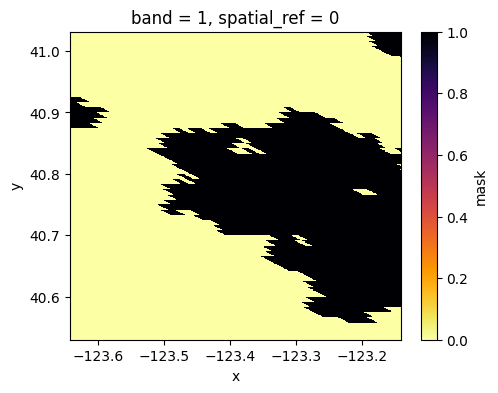

In [79]:
import rioxarray as xr
tra_scene_sample = xr.open_rasterio(fire_masks_path + '/MODIS_061_MOD14A1_4.tif')
print(tra_scene_sample.shape)
tra_scene_sample.coords
tra_scene_sample.plot(size=4, cmap="inferno_r")

Ojo!! tra_scene_sample puede no tener asignado CRS al haber usado el Reducer

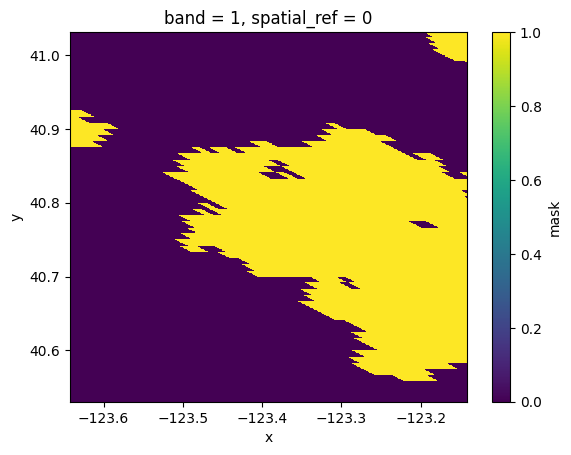

In [80]:
tra_scene_sample.sel(band=[1]).plot()#.astype("int").plot.imshow(rgb="band")

In [297]:
%rm -Rf ./data/mask/

In [298]:
%mkdir -p ./data/mask/
%cp "{out_path}" ./data/mask/
%ls -al  ./data/mask/

total 28
drwxr-xr-x 2 root root  4096 Jan 26 12:44 ./
drwxr-xr-x 4 root root  4096 Jan 26 12:44 ../
-rw------- 1 root root 20326 Jan 26 12:44 dixie_mask.tif


(1, 1559, 1559)


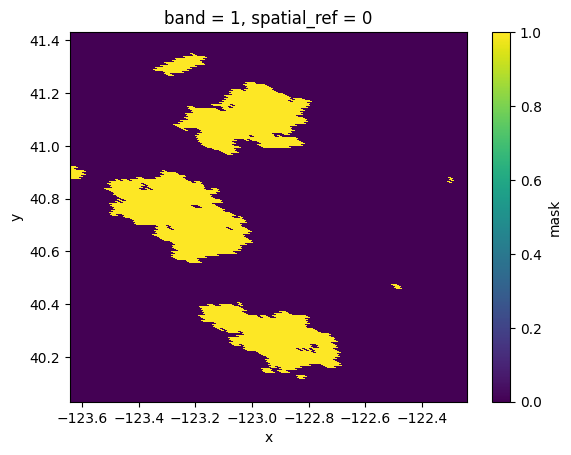

In [299]:
import rioxarray as xr
tra_scene_sample = xr.open_rasterio('./data/mask/dixie_mask.tif')
print(tra_scene_sample.shape)
tra_scene_sample.coords
tra_scene_sample.sel(band=[1]).plot()#.astype("int").plot.imshow(rgb="band")

In [82]:
%cp  -a "{fire_masks_path}/." ./data/mask/
%ls -al "{fire_masks_path}"

total 31
-rw------- 1 root root 2382 Jan 26 11:32 MODIS_061_MOD14A1_1.tif
-rw------- 1 root root 4742 Jan 26 11:32 MODIS_061_MOD14A1_2.tif
-rw------- 1 root root 2016 Jan 26 11:32 MODIS_061_MOD14A1_3.tif
-rw------- 1 root root 5622 Jan 26 11:33 MODIS_061_MOD14A1_4.tif
-rw------- 1 root root 4047 Jan 26 11:33 MODIS_061_MOD14A1_5.tif
-rw------- 1 root root 2040 Jan 26 11:33 MODIS_061_MOD14A1_6.tif
-rw------- 1 root root 3519 Jan 26 11:33 MODIS_061_MOD14A1_7.tif
-rw------- 1 root root 3658 Jan 26 11:33 MODIS_061_MOD14A1_8.tif
-rw------- 1 root root 1940 Jan 26 11:33 MODIS_061_MOD14A1_9.tif


**TODO**: Calcular el total de la superficie quemada

## LandCovers

TODOS:

* Dates must be adjusted to get the state previous to the wildfire
* Get several dates and select the less cloudy image or https://github.com/csaybar/EEwPython/blob/master/dnn_demo.ipynb

In [277]:
import geemap
# start = ee.Date('2021-07-30')
# end = ee.Date('2021-09-05')

collection = (
  ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(safe_bbox)
    .filter(ee.Filter.listContains("system:band_names", "B4"))
    .filter(ee.Filter.listContains("system:band_names", "B3"))
    .filter(ee.Filter.listContains("system:band_names", "B2"))
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .select(['B2', 'B3', 'B4', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB'])
    .filterDate(start, end) # Fire dates
)

# Because cloud probability ranges from 0 to 100 percent (low to high), we need
# to invert the MSK_CLDPRB band values so that low cloud probability pixels
# indicate high quality. Here, an inverting function is mapped over the
# image collection, the inverted MSK_CLDPRB band is added as a "quality" band.
def invertCloudProbabilityBand(img):
  cldProb = img.select('MSK_CLDPRB')
  cldProbInv = cldProb.multiply(-1).rename('quality')
  return img.addBands(cldProbInv)

collection = collection.map(invertCloudProbabilityBand)

img = collection.qualityMosaic('quality').clip(bbox)


# Get the number of images in the collection.
print('* Number of images:', collection.size().getInfo())
collection_crs = collection.first().geometry().projection().getInfo()['crs']
print('* collection_crs:', collection_crs)

img

* Number of images: 58
* collection_crs: EPSG:4326


In [84]:
safe_bbox

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Geometry.buffer",
    "arguments": {
      "distance": {
        "constantValue": 10000
      },
      "geometry": {
        "functionInvocationValue": {
          "functionName": "GeometryConstructors.Polygon",
          "arguments": {
            "coordinates": {
              "constantValue": [
                [
                  [
                    -123.642,
                    41.431000000000004
                  ],
                  [
                    -123.642,
                    40.031
                  ],
                  [
                    -122.24199999999999,
                    40.031
                  ],
                  [
                    -122.24199999999999,
                    41.431000000000004
                  ]
                ]
              ]
            },
            "geodesic": {
              "constantValue": false
            }
          }
        }
      }
    }
  }
})

In [278]:
images_crs = collection_crs
print('* images_crs:', images_crs)

* images_crs: EPSG:4326


In [86]:
%rm -Rf "{land_covers_path}"

In [87]:
geemap.download_ee_image_tiles(image=img, features=fishnet, out_dir=land_covers_path, prefix=land_covers_prefix, scale=100, crs=collection_crs)

COPERNICUS_S2_SR_HARMONIZED_1.tif: |          | 0.00/9.93M (raw) [  0.0%] in 00:00 (eta:     ?)

COPERNICUS_S2_SR_HARMONIZED_2.tif: |          | 0.00/9.95M (raw) [  0.0%] in 00:00 (eta:     ?)

COPERNICUS_S2_SR_HARMONIZED_3.tif: |          | 0.00/9.95M (raw) [  0.0%] in 00:00 (eta:     ?)

COPERNICUS_S2_SR_HARMONIZED_4.tif: |          | 0.00/9.95M (raw) [  0.0%] in 00:00 (eta:     ?)

COPERNICUS_S2_SR_HARMONIZED_5.tif: |          | 0.00/9.96M (raw) [  0.0%] in 00:00 (eta:     ?)

COPERNICUS_S2_SR_HARMONIZED_6.tif: |          | 0.00/9.96M (raw) [  0.0%] in 00:00 (eta:     ?)

COPERNICUS_S2_SR_HARMONIZED_7.tif: |          | 0.00/9.95M (raw) [  0.0%] in 00:00 (eta:     ?)

COPERNICUS_S2_SR_HARMONIZED_8.tif: |          | 0.00/9.96M (raw) [  0.0%] in 00:00 (eta:     ?)

COPERNICUS_S2_SR_HARMONIZED_9.tif: |          | 0.00/9.96M (raw) [  0.0%] in 00:00 (eta:     ?)

Downloaded 9 tiles in 113.29006862640381 seconds.


In [88]:
%ls -al "{land_covers_path}"

total 27073
-rw------- 1 root root 3419393 Jan 26 11:33 COPERNICUS_S2_SR_HARMONIZED_1.tif
-rw------- 1 root root 3365034 Jan 26 11:33 COPERNICUS_S2_SR_HARMONIZED_2.tif
-rw------- 1 root root 2885161 Jan 26 11:34 COPERNICUS_S2_SR_HARMONIZED_3.tif
-rw------- 1 root root 3552865 Jan 26 11:34 COPERNICUS_S2_SR_HARMONIZED_4.tif
-rw------- 1 root root 3603693 Jan 26 11:34 COPERNICUS_S2_SR_HARMONIZED_5.tif
-rw------- 1 root root 2834679 Jan 26 11:34 COPERNICUS_S2_SR_HARMONIZED_6.tif
-rw------- 1 root root 2826494 Jan 26 11:34 COPERNICUS_S2_SR_HARMONIZED_7.tif
-rw------- 1 root root 3023912 Jan 26 11:35 COPERNICUS_S2_SR_HARMONIZED_8.tif
-rw------- 1 root root 2208230 Jan 26 11:35 COPERNICUS_S2_SR_HARMONIZED_9.tif


In [279]:
# Downloads all at one image
out_filename = 'dixie.tif'
out_path = os.path.join(out_dir, out_filename)
print('* out_path:', out_path)
print('* out_dir:', out_dir)
geemap.download_ee_image(img, out_path, crs=collection_crs, region=bbox, scale=100)

* out_path: /content/drive/My Drive/upc_project_dataset/dixie.tif
* out_dir: /content/drive/My Drive/upc_project_dataset


dixie.tif: |          | 0.00/77.8M (raw) [  0.0%] in 00:00 (eta:     ?)

In [281]:
%rm -Rf ./data/scene/
%mkdir -p ./data/scene/
%cp "{out_path}" ./data/scene/

In [282]:
import xarray
tra_scene_sample = xr.open_rasterio('./data/scene/dixie.tif')
# tra_scene_sample = xarray.open_dataarray(land_covers_path + '/COPERNICUS_S2_SR_HARMONIZED_4.tif')
print(tra_scene_sample.shape)
print(tra_scene_sample.coords)

(8, 1559, 1559)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8
  * x            (x) float64 -123.6 -123.6 -123.6 ... -122.2 -122.2 -122.2
  * y            (y) float64 41.43 41.43 41.43 41.43 ... 40.03 40.03 40.03 40.03
    spatial_ref  int64 0


In [89]:
import xarray
tra_scene_sample = xr.open_rasterio(land_covers_path + '/COPERNICUS_S2_SR_HARMONIZED_9.tif')
# tra_scene_sample = xarray.open_dataarray(land_covers_path + '/COPERNICUS_S2_SR_HARMONIZED_4.tif')
print(tra_scene_sample.shape)
print(tra_scene_sample.coords)

(8, 558, 558)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8
  * x            (x) float64 -122.6 -122.6 -122.6 ... -122.1 -122.1 -122.1
  * y            (y) float64 41.53 41.53 41.53 41.53 ... 41.03 41.03 41.03 41.03
    spatial_ref  int64 0


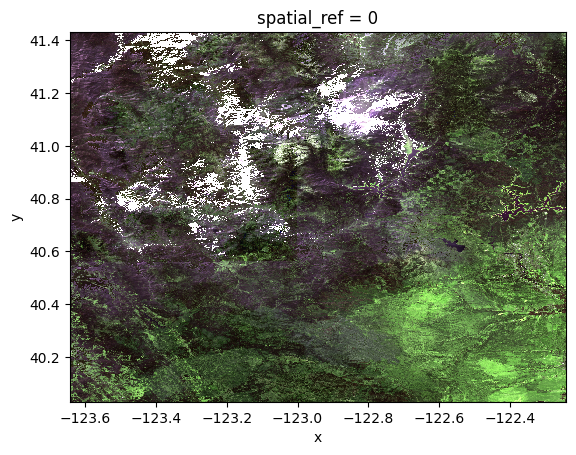

In [283]:
#tra_scene_sample.sel(band=[1,2,3]).plot.imshow()
tra_scene_sample.sel(band=[5,4,6]).plot.imshow(rgb="band")

In [91]:
tra_scene_sample.coords

Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8
  * x            (x) float64 -122.6 -122.6 -122.6 ... -122.1 -122.1 -122.1
  * y            (y) float64 41.53 41.53 41.53 41.53 ... 41.03 41.03 41.03 41.03
    spatial_ref  int64 0

In [92]:
tra_scene_sample.spatial_ref.crs_wkt

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'

In [93]:
%rm -rf ./data/scene

In [94]:
%cp  -a "{land_covers_path}/." ./data/scene/
%ls -al "{land_covers_path}"

total 27073
-rw------- 1 root root 3419393 Jan 26 11:33 COPERNICUS_S2_SR_HARMONIZED_1.tif
-rw------- 1 root root 3365034 Jan 26 11:33 COPERNICUS_S2_SR_HARMONIZED_2.tif
-rw------- 1 root root 2885161 Jan 26 11:34 COPERNICUS_S2_SR_HARMONIZED_3.tif
-rw------- 1 root root 3552865 Jan 26 11:34 COPERNICUS_S2_SR_HARMONIZED_4.tif
-rw------- 1 root root 3603693 Jan 26 11:34 COPERNICUS_S2_SR_HARMONIZED_5.tif
-rw------- 1 root root 2834679 Jan 26 11:34 COPERNICUS_S2_SR_HARMONIZED_6.tif
-rw------- 1 root root 2826494 Jan 26 11:34 COPERNICUS_S2_SR_HARMONIZED_7.tif
-rw------- 1 root root 3023912 Jan 26 11:35 COPERNICUS_S2_SR_HARMONIZED_8.tif
-rw------- 1 root root 2208230 Jan 26 11:35 COPERNICUS_S2_SR_HARMONIZED_9.tif


## Intersection

One point we need to pay attention is to inform the RasterDataset class that our masks are not “images”. This way, when a sample is drawn from the masks dataset, it will return the data coupled with the “mask” key, instead of the “image” key, normally used in the images

In [300]:
import torch
from pathlib import Path
from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomBatchGeoSampler, RandomGeoSampler, Units
from torch.utils.data import DataLoader

root = Path('data')
assert root.exists()

root.as_posix()

def scale(item: dict):
    item['image'] = item['image'] / 10000
    return item


print('* images_crs:', images_crs)
print('* masks_crs:', masks_crs)

* images_crs: EPSG:4326
* masks_crs: EPSG:4326


In [246]:
# # train_imgs = RasterDataset(paths=(root/'scene').as_posix(), crs='epsg:3395', res=10, transforms=scale)
# train_imgs = RasterDataset(paths=(root/'scene').as_posix(), crs='epsg:32610', transforms=scale)
# # !! OJO crs='epsg:3395' => 26910
# train_msks = RasterDataset(paths=(root/'mask').as_posix())


# # IMPORTANT
# train_msks.is_image = False

In [301]:
train_imgs = RasterDataset(paths=(root/'scene').as_posix(), crs=images_crs, transforms=scale)
train_msks = RasterDataset(paths=(root/'mask').as_posix(), crs=masks_crs)
# train_imgs = RasterDataset(paths=(root/'scene').as_posix(), transforms=scale)
# train_msks = RasterDataset(paths=(root/'mask').as_posix())
train_msks.is_image = False

[RandomGeoSampler](https://torchgeo.readthedocs.io/en/latest/api/samplers.html#torchgeo.samplers.RandomGeoSampler): This sampler is **not recommended** for use with tile-based datasets. Use RandomBatchGeoSampler instead.

In [302]:
train_msks.index

rtree.index.Index(bounds=[-123.6423190756427, -122.24184554770036, 40.03072569093412, 41.43119921887645, 0.0, 9.223372036854776e+18], size=1)

In [303]:
bbox_list


[-123.642, 40.031, -122.24199999999999, 41.431000000000004]

In [332]:
# length: number of random samples to draw per epoch (defaults to approximately the maximal number of non-overlapping chips of size that could be sampled from the dataset)
sampler = RandomGeoSampler(train_imgs, size=256, length=30, units=Units.PIXELS)
# del sampler

batch_sampler = RandomBatchGeoSampler(train_imgs, size=256, batch_size=8, length=60, units=Units.PIXELS)
del batch_sampler
#batch_sampler = RandomBatchGeoSampler(train_imgs, size=512, batch_size=4, length=30, units=Units.PIXELS)


In [333]:
# let's get a random bounding box, just to check the datasets
_bbox = next(iter(sampler))
_bbox

BoundingBox(minx=-123.48369542441411, maxx=-123.2537267116795, miny=40.37713675789153, maxy=40.607105470626124, mint=0.0, maxt=9.223372036854776e+18)

In [334]:
import matplotlib.pyplot as plt

from typing import Iterable, List
def plot_imgs(images: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 3.):
    arr = torch.clamp(bright * images, min=0, max=1).numpy()
    rgb = arr.transpose(1, 2, 0)[:, :, chnls]
    #rgb = arr.transpose(2, 1, 0)[:, :, [2, 1 , 0]]
    plt.imshow(rgb)
    plt.axis('off')

def plot_msks(mask: Iterable):
        plt.imshow(mask.squeeze().numpy())
        plt.axis('off')

In [335]:
train_imgs[_bbox]

{'crs': 'EPSG:4326',
 'bbox': BoundingBox(minx=-123.48369542441411, maxx=-123.2537267116795, miny=40.37713675789153, maxy=40.607105470626124, mint=0.0, maxt=9.223372036854776e+18),
 'image': tensor([[[0.0686, 0.0839, 0.0856,  ..., 0.0688, 0.0720, 0.0683],
          [0.0714, 0.0684, 0.0779,  ..., 0.0540, 0.0533, 0.0486],
          [0.0585, 0.0613, 0.0608,  ..., 0.0459, 0.0434, 0.0466],
          ...,
          [0.0411, 0.0435, 0.0496,  ..., 0.0419, 0.0361, 0.0312],
          [0.0549, 0.0541, 0.0521,  ..., 0.0355, 0.0343, 0.0322],
          [0.0600, 0.0523, 0.0535,  ..., 0.0322, 0.0369, 0.0358]],
 
         [[0.0729, 0.0874, 0.0894,  ..., 0.0724, 0.0764, 0.0707],
          [0.0821, 0.0749, 0.0822,  ..., 0.0586, 0.0581, 0.0533],
          [0.0648, 0.0707, 0.0711,  ..., 0.0550, 0.0532, 0.0541],
          ...,
          [0.0515, 0.0514, 0.0582,  ..., 0.0517, 0.0457, 0.0395],
          [0.0613, 0.0636, 0.0620,  ..., 0.0469, 0.0420, 0.0407],
          [0.0627, 0.0564, 0.0600,  ..., 0.0431, 0.

dict_keys(['crs', 'bbox', 'image'])
torch.Size([8, 256, 256])


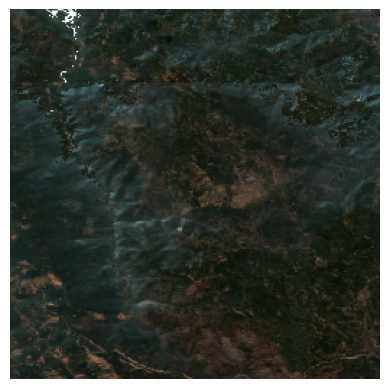

In [336]:
_sample = train_imgs[_bbox]
print(_sample.keys())
print(_sample['image'].shape)
plot_imgs(images=_sample['image'])

In [337]:
img_sample = train_imgs[_bbox]
msk_sample = train_msks[_bbox]
print(img_sample.keys(), msk_sample.keys())
print()
print(img_sample['image'].shape, msk_sample['mask'].shape)

dict_keys(['crs', 'bbox', 'image']) dict_keys(['crs', 'bbox', 'mask'])

torch.Size([8, 256, 256]) torch.Size([1, 256, 256])


In [338]:
msk_sample['mask'][0]

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

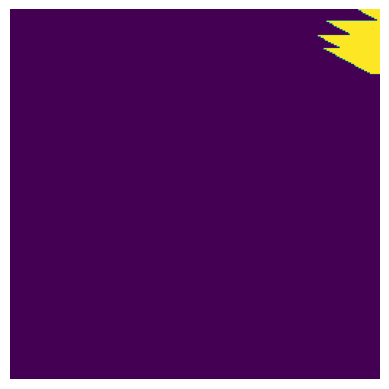

In [339]:
plot_msks(mask=msk_sample['mask'][0])

In [340]:
# let's assert the patches cover the same region...
print(img_sample['bbox'])
print(msk_sample['bbox'])
assert img_sample['bbox'] == msk_sample['bbox']

BoundingBox(minx=-123.48369542441411, maxx=-123.2537267116795, miny=40.37713675789153, maxy=40.607105470626124, mint=0.0, maxt=9.223372036854776e+18)
BoundingBox(minx=-123.48369542441411, maxx=-123.2537267116795, miny=40.37713675789153, maxy=40.607105470626124, mint=0.0, maxt=9.223372036854776e+18)


Now, when we draw samples from this new dataset, the resulting directory shall has an entry with the image data (already scaled by 10,000) and an entry with the masks.

In [341]:
print(train_imgs.bounds)
print(train_imgs.res)

BoundingBox(minx=-123.6423190756427, maxx=-122.24184554770036, miny=40.03072569093412, maxy=41.43119921887645, mint=0.0, maxt=9.223372036854776e+18)
0.0008983152841195215


In [342]:
print(train_msks.bounds)
print(train_msks.res)

BoundingBox(minx=-123.6423190756427, maxx=-122.24184554770036, miny=40.03072569093412, maxy=41.43119921887645, mint=0.0, maxt=9.223372036854776e+18)
0.0008983152841195215


In [343]:
# train_dset = train_imgs & train_msks
train_dset = train_msks & train_imgs

# This to test but should be an intersect, not an union
#train_dset = train_imgs | train_msks

sample = train_dset[_bbox]
sample.keys()

dict_keys(['crs', 'bbox', 'mask', 'image'])

In [344]:
dataloader = DataLoader(train_dset, sampler=sampler, batch_size=12, collate_fn=stack_samples)
# dataloader = DataLoader(train_dset, batch_sampler=batch_sampler, collate_fn=stack_samples)
batch = next(iter(dataloader))
batch.keys()

dict_keys(['crs', 'bbox', 'mask', 'image'])

In [345]:
#batch['image']

In [346]:
print(train_dset.index)

rtree.index.Index(bounds=[-123.6423190756427, -122.24184554770036, 40.03072569093412, 41.43119921887645, 0.0, 9.223372036854776e+18], size=1)


In [347]:
from typing import Iterable, List


def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        # ax.imshow(mask.squeeze().numpy(), cmap='Blues')
        ax.imshow(mask.squeeze().numpy())
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [2, 1, 0]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())

    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright) #type: ignore

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2]) #type: ignore

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright) #type: ignore

        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)) #type: ignore

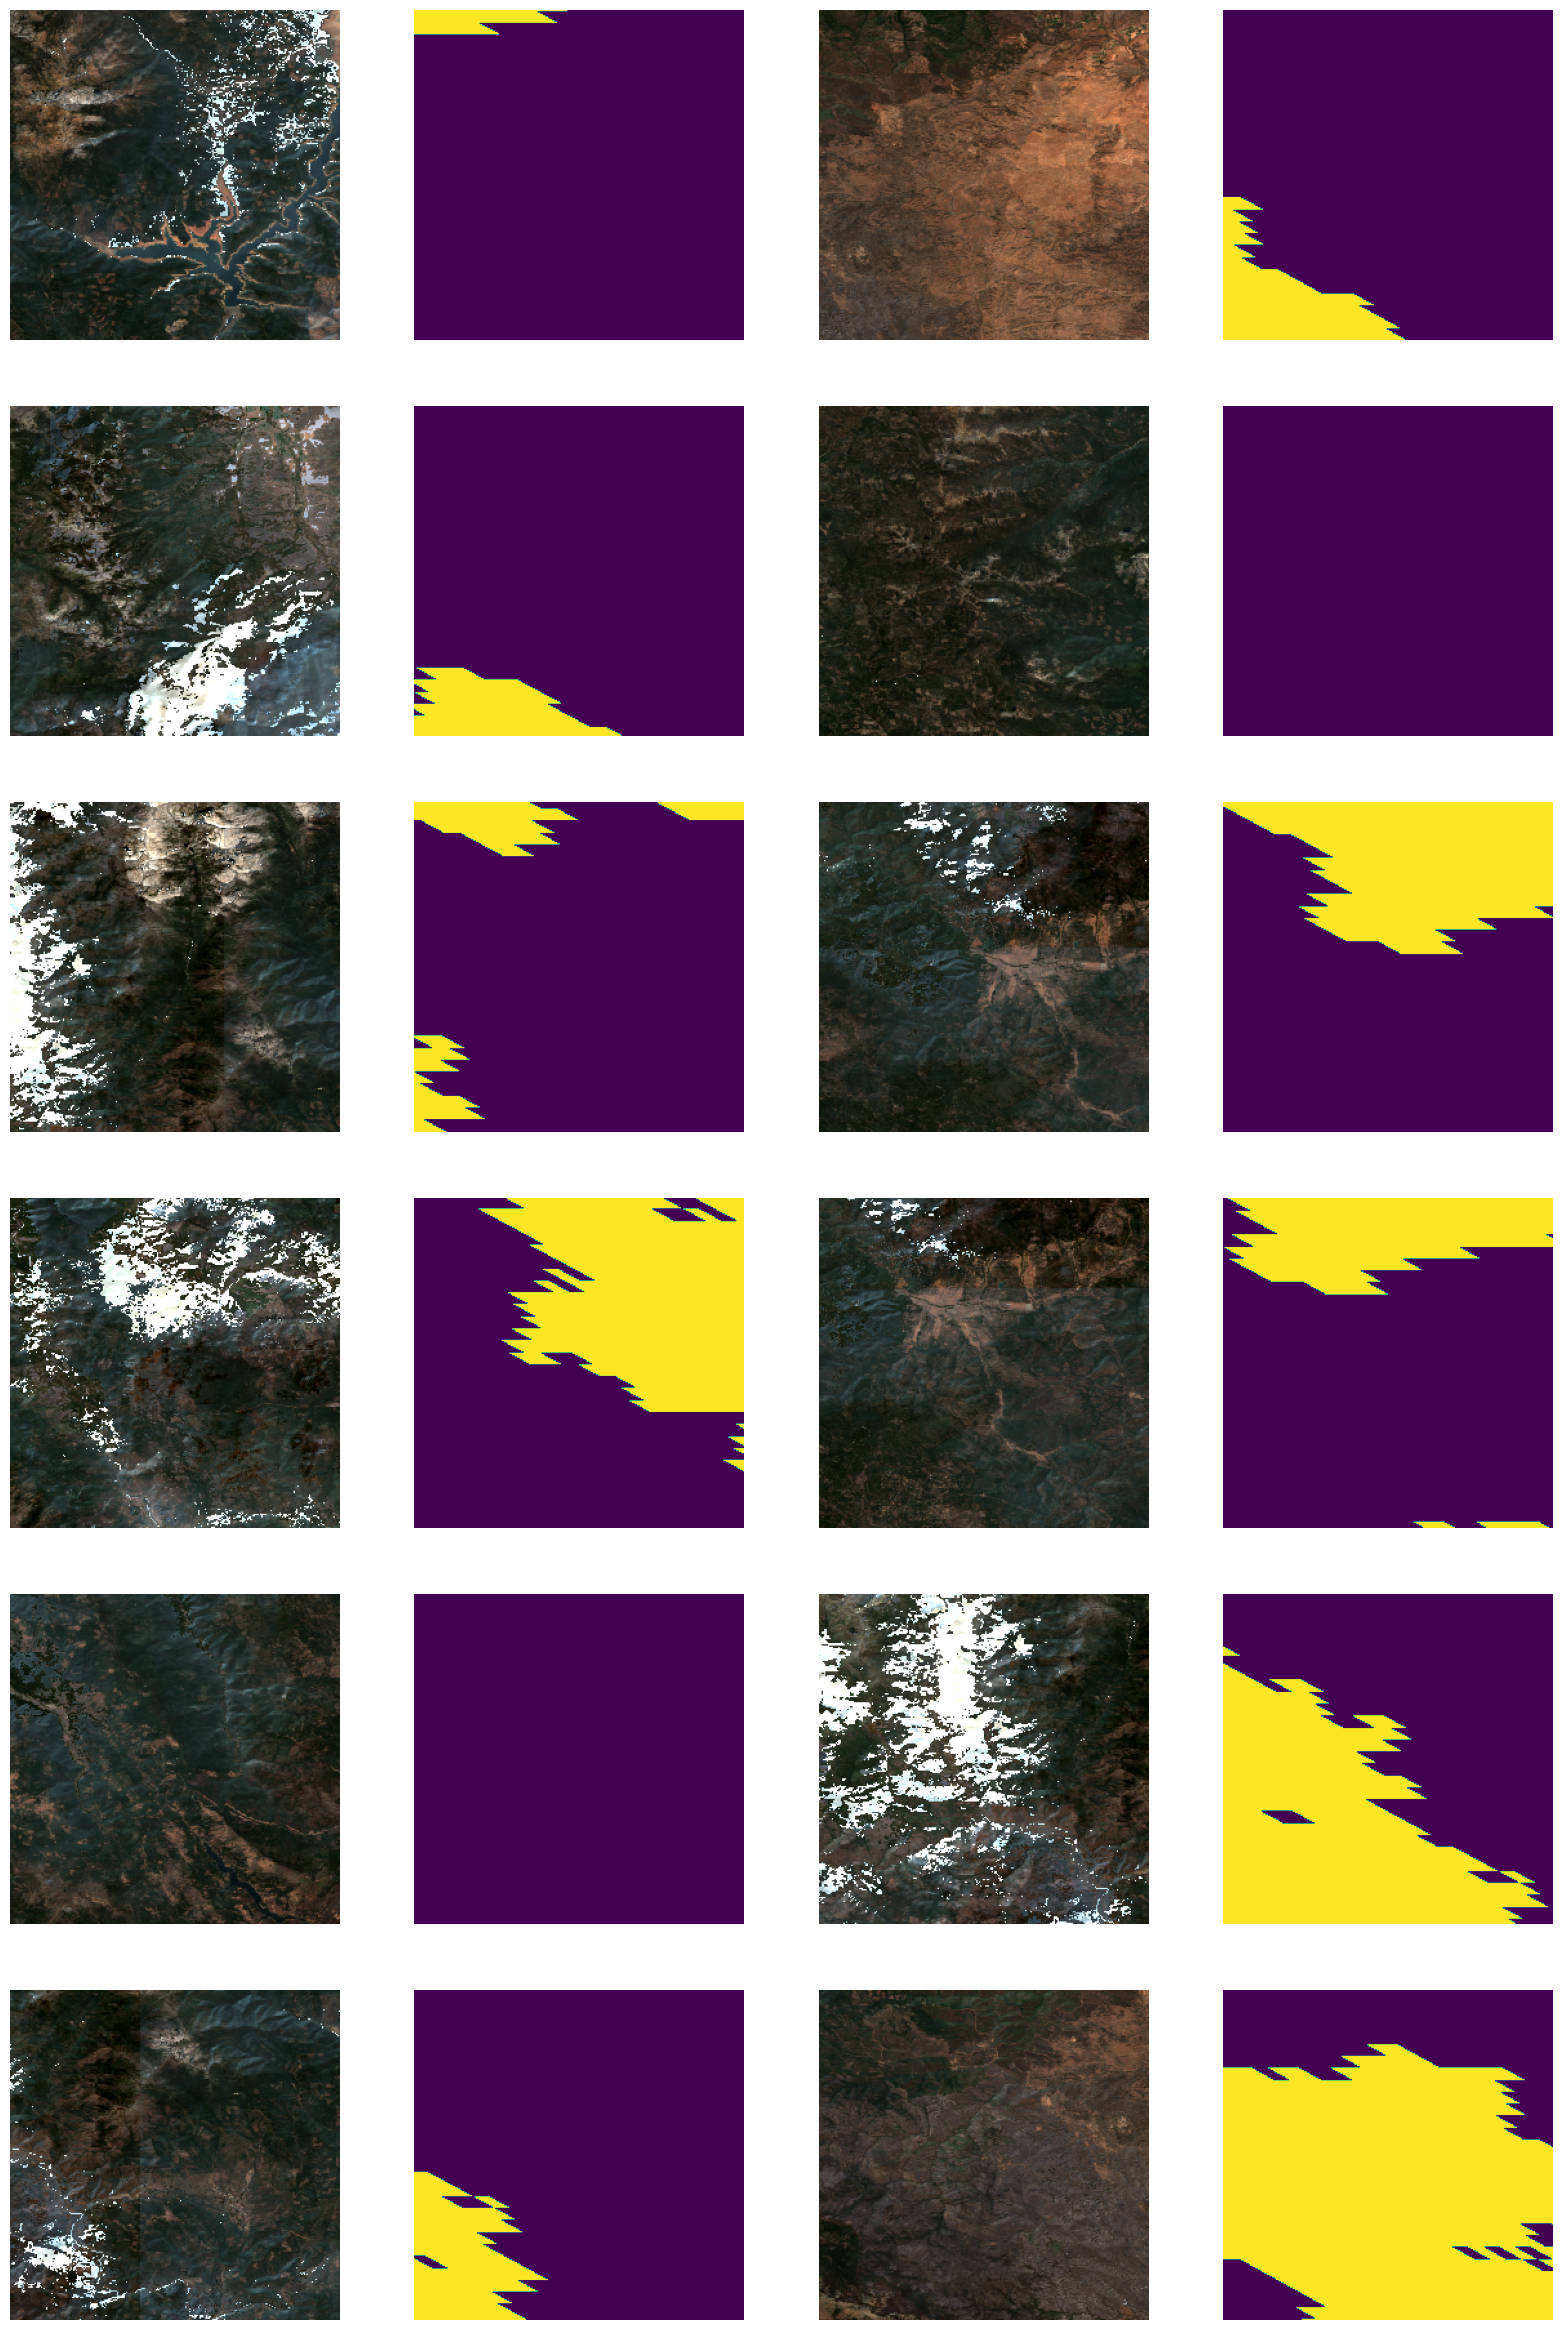

In [348]:
plot_batch(batch)

In [351]:
for sample in dataloader:
    image = sample["image"]
    target = sample["mask"]
    print(target[0][[0]].size())

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


In [354]:
sample = next(iter(sampler))
datapoint = train_dset[sample]
print(datapoint['mask'].shape)
print(datapoint['image'].shape)

torch.Size([1, 256, 256])
torch.Size([8, 256, 256])


In [ ]:
sample = next(iter(batch_sampler))
sample